<a href="https://colab.research.google.com/github/spdsp04/melanoma_detection_Durgesh_Chaubey_CNN/blob/main/Durgesh_Chaubey_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement (Melanoma Detection)

>To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

>The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

In [1]:
# Importing Libraries

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Rescaling, InputLayer

### Importing Dataset from Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Image checking with keras.preprocessing tool**

Let's use the image_dataset_from_directory utility to check data.

**Setting up dataset**

finallising size of data for loader

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
# Classifying train (70%) and validation data (30%)
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  label_mode="int",
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1568 files for training.


In [7]:
# Classifying validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  label_mode="int",
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 671 files for validation.


In [8]:
# Listing out all the classes of skin cancer
class_names = train_dataset.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [9]:
# Listing out train images in each classes
for i in class_names:
  print(i,": ",len(list(data_dir_train.glob('{}/*.jpg'.format(i)))))

actinic keratosis :  114
basal cell carcinoma :  376
dermatofibroma :  95
melanoma :  438
nevus :  357
pigmented benign keratosis :  462
seborrheic keratosis :  77
squamous cell carcinoma :  181
vascular lesion :  139


In [10]:
# Listing out test images in each classes
for i in class_names:
  print(i,": ",len(list(data_dir_test.glob('{}/*.jpg'.format(i)))))

actinic keratosis :  16
basal cell carcinoma :  16
dermatofibroma :  16
melanoma :  16
nevus :  16
pigmented benign keratosis :  16
seborrheic keratosis :  3
squamous cell carcinoma :  16
vascular lesion :  3


### Data Visulisation   

Visualizing one instance of all the nine classes present in the dataset

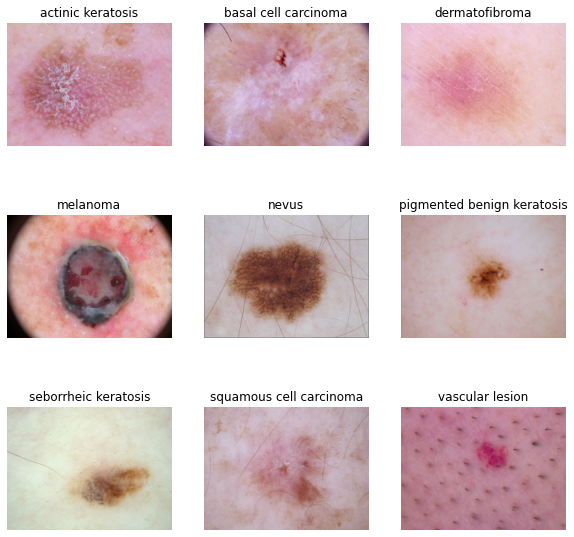

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for index,images in enumerate(class_names):
  
  temp=plt.imread(list(data_dir_train.glob('{}/*.jpg'.format(images)))[0])
  
  plt.subplot(3,3,index+1)
  plt.imshow(temp)
  plt.axis('off')
  plt.title(images)

In [12]:
# Checking shape of image
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general we should seek to make our input values small.

Standardize values should to be in the [0, 1] range.

In [14]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

### Create the model (Model 1)

Creating a CNN model, which can accurately detect 9 classes present in the dataset.

In [15]:
model=Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])

model.add(Conv2D(16, 3, activation='relu',padding='same', input_shape = (180, 180, 32)))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, activation='relu',padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, activation='relu',padding='same'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(9, activation='softmax'))

#### Compile the model

Choosing the following appropirate optimiser and loss function for model training

In [16]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

Train the model

In [20]:
epochs = 20
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/20
49/49 [==============================] - 153s 3s/step - loss: 2.0541 - accuracy: 0.1952 - val_loss: 1.9519 - val_accuracy: 0.2459
Epoch 2/20
49/49 [==============================] - 51s 1s/step - loss: 1.8436 - accuracy: 0.3240 - val_loss: 1.7069 - val_accuracy: 0.4411
Epoch 3/20
49/49 [==============================] - 51s 1s/step - loss: 1.6197 - accuracy: 0.4394 - val_loss: 1.5426 - val_accuracy: 0.5007
Epoch 4/20
49/49 [==============================] - 51s 1s/step - loss: 1.4906 - accuracy: 0.4649 - val_loss: 1.5528 - val_accuracy: 0.5052
Epoch 5/20
49/49 [==============================] - 51s 1s/step - loss: 1.3730 - accuracy: 0.5070 - val_loss: 1.4697 - val_accuracy: 0.5007
Epoch 6/20
49/49 [==============================] - 51s 1s/step - loss: 1.2572 - accuracy: 0.5580 - val_loss: 1.4383 - val_accuracy: 0.5082
Epoch 7/20
49/49 [==============================] - 51s 1s/step - loss: 1.1753 - accuracy: 0.5765 - val_loss: 1.4039 - val_accuracy: 0.5156
Epoch 8/20
49/49 [=

Visualizing training results

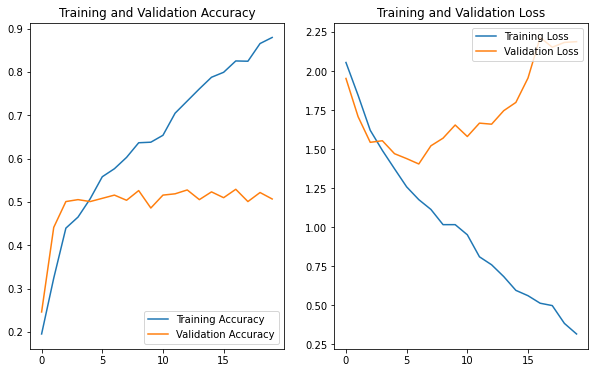

In [26]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Result:

Train Accuracy - 0.88

Train Loss - 0.29

Validation Accuracy - 0.56

Validation Loss - 2.11

Findings:

Clearly by comparing the above results we can say that the model is overfitting as we have high Train Accuracy and Low Validation Accuracy. Also Loss value is higher in validation dataset than train dataset.

Solution:

Need to do some changes in model like doing data augmentation, including dropout in layers

**Data Augmentation**

Applying Data Augmentation technique like Flip, Rotate, Zoom for input dataset then we can build the model and check for results. 

In [27]:
image_aug = keras.Sequential([layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')])

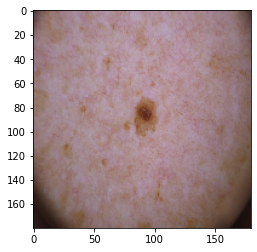

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_aug1=ImageDataGenerator(rescale=1./255,
                   horizontal_flip=True,
                   zoom_range=0.2)
image_batch,label_batch=next(iter(train_dataset))
temp=image_batch[0].numpy()
plt.imshow(temp.astype('uint8'))

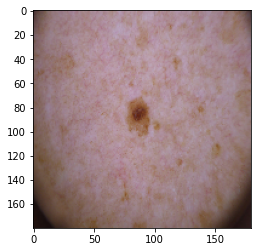

In [30]:
#visualize how your augmentation strategy works for one instance of training image.
plt.imshow(image_aug1.apply_transform(temp,transform_parameters={'flip_horizontal':True}).astype('uint8'))

### Model 2:

In [31]:
# Create the model
model1=Sequential([image_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model1.add(Conv2D(16, 3, activation='relu',padding='same',input_shape = (180, 180, 32)))
model1.add(MaxPooling2D())

model1.add(Conv2D(32, 3, activation='relu',padding='same'))
model1.add(MaxPooling2D())
model1.add(Conv2D(64, 3, activation='relu',padding='same'))
model1.add(MaxPooling2D())
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(9, activation='softmax'))

In [32]:
# Compile the model
model1.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [33]:
# View the summary of all layers
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [35]:
# Training the model
epochs = 20
history = model1.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/20
49/49 [==============================] - 61s 1s/step - loss: 2.1147 - accuracy: 0.2277 - val_loss: 1.9402 - val_accuracy: 0.2921
Epoch 2/20
49/49 [==============================] - 62s 1s/step - loss: 1.8557 - accuracy: 0.3042 - val_loss: 1.8120 - val_accuracy: 0.3323
Epoch 3/20
49/49 [==============================] - 61s 1s/step - loss: 1.7441 - accuracy: 0.3871 - val_loss: 1.6453 - val_accuracy: 0.3905
Epoch 4/20
49/49 [==============================] - 60s 1s/step - loss: 1.5373 - accuracy: 0.4464 - val_loss: 1.5812 - val_accuracy: 0.4590
Epoch 5/20
49/49 [==============================] - 61s 1s/step - loss: 1.4181 - accuracy: 0.5038 - val_loss: 1.4460 - val_accuracy: 0.5082
Epoch 6/20
49/49 [==============================] - 61s 1s/step - loss: 1.3978 - accuracy: 0.5077 - val_loss: 1.4452 - val_accuracy: 0.4769
Epoch 7/20
49/49 [==============================] - 61s 1s/step - loss: 1.3673 - accuracy: 0.5070 - val_loss: 1.3317 - val_accuracy: 0.5171
Epoch 8/20
49/49 [==

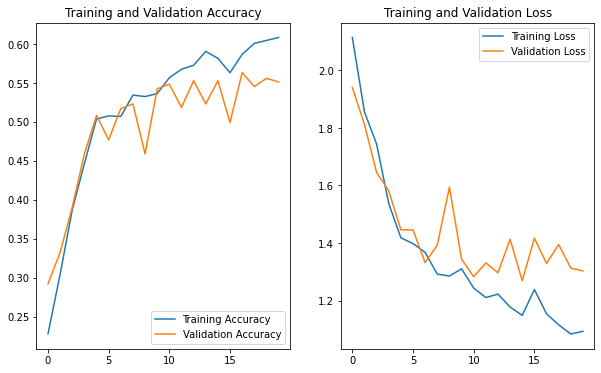

In [36]:
# Visualizing the result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Result:**

Train Accuracy - 0.58

Validation Accuracy - 0.54

Train Loss - 1.13

Validation Loss - 1.32

**Findings:**

From the above results we can see that model is underfitting. Eventhough Train and validation accuracy is almost near but the value is less we got only 55% which is not good accuracy. 

**Solution:**

We can check for class imbalance and rectify using Augmentor package, can do batch normalization, dropout in layers. 

**Checking for class imbalance:**

Many datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [37]:
for i in class_names:
  print(i,": ",len(list(data_dir_train.glob('{}/*.jpg'.format(i)))))

actinic keratosis :  114
basal cell carcinoma :  376
dermatofibroma :  95
melanoma :  438
nevus :  357
pigmented benign keratosis :  462
seborrheic keratosis :  77
squamous cell carcinoma :  181
vascular lesion :  139


<BarContainer object of 9 artists>

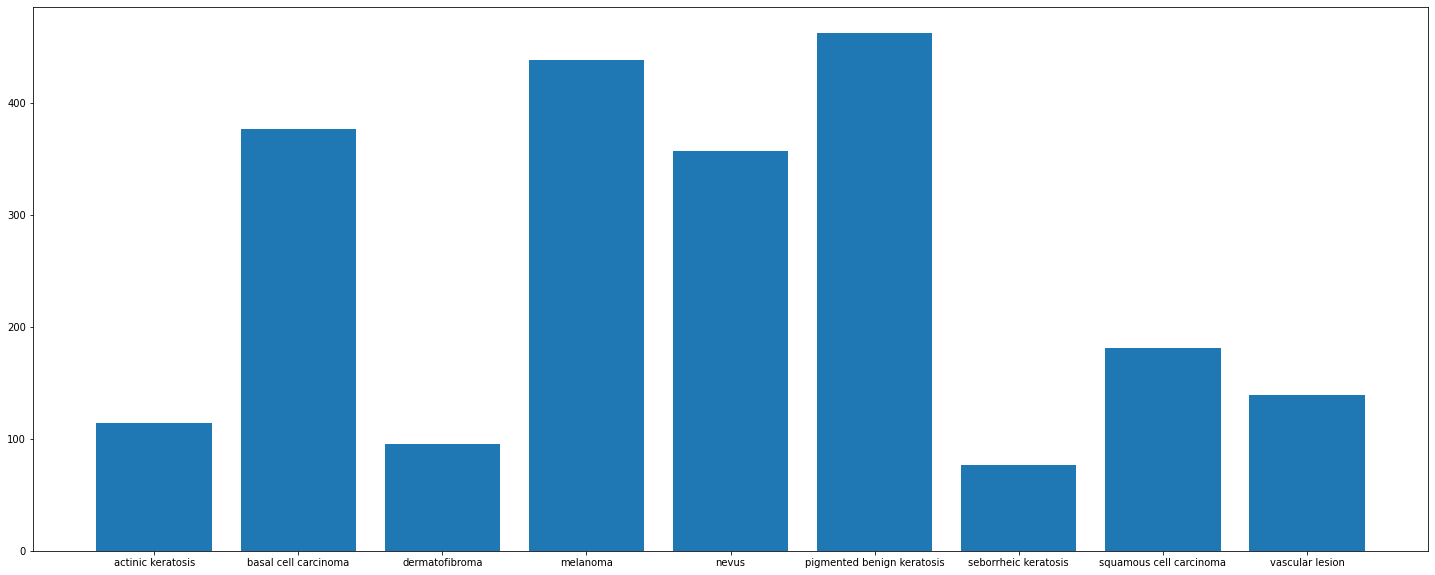

In [38]:
# Visualize class imbalance through chart
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

**'seborrheic keratosis'** has lowest number of image with 77

**'pigmented benign keratosis'** has more dominent(higher) number of image with 462 

In [40]:
# checking label
path_list=[]
lesion_list=[]
for i in class_names:
      for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
1,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
2,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
3,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
4,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion
2235,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion
2236,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion
2237,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion


**Augmentor Package**

A python package known as Augmentor is used to add more samples across all classes so that none of the classes have very few samples.

In [43]:
import Augmentor
for i in class_names:
  augmnt_pipeline = Augmentor.Pipeline(str(data_dir_train) + '/'+ i)
  augmnt_pipeline.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  augmnt_pipeline.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE572A28B90>: 100%|██████████| 500/500 [00:26<00:00, 19.18 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE572978D10>: 100%|██████████| 500/500 [00:26<00:00, 18.59 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE572868CD0>: 100%|██████████| 500/500 [00:27<00:00, 18.22 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FE572978750>: 100%|██████████| 500/500 [02:05<00:00,  3.97 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FE571588250>: 100%|██████████| 500/500 [01:38<00:00,  5.08 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE57414E250>: 100%|██████████| 500/500 [00:22<00:00, 21.77 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FE572845C90>: 100%|██████████| 500/500 [00:51<00:00,  9.78 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE572974450>: 100%|██████████| 500/500 [00:23<00:00, 21.13 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE572978210>: 100%|██████████| 500/500 [00:23<00:00, 21.18 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [44]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Checking distribution of augmented data after adding new images to the original training data.**

In [45]:
import os
import glob
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [46]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [47]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [48]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [49]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

Now we have added 500 images to all the classes to maintain some class balance.

In [50]:
batch_size = 32
img_height = 180
img_width = 180

**Creating a training dataset**

In [51]:
augmented_data_dir = data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  augmented_data_dir,
  seed=123,
  validation_split = 0.2,
  subset ='training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Creating a validation dataset

In [53]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  augmented_data_dir,
  seed=123,
  validation_split = 0.2,
  subset ='validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Model 3:

In [54]:
# Include BatchNormalization, Dropout
model_norm=Sequential()

model_norm.add(InputLayer((180,180,3)))
model_norm.add(Rescaling(1./255))

model_norm.add(Conv2D(32, (3, 3), padding='same'))
model_norm.add(BatchNormalization())
model_norm.add(Activation('relu'))

model_norm.add(MaxPooling2D(pool_size=(2, 2)))

model_norm.add(Conv2D(64, (3, 3)))
model_norm.add(BatchNormalization())
model_norm.add(Activation('relu'))


model_norm.add(MaxPooling2D(pool_size=(2, 2)))
model_norm.add(Dropout(0.25))

model_norm.add(Flatten())
model_norm.add(Dense(512, activation='relu'))
model_norm.add(Dense(256, activation='relu'))
model_norm.add(Dropout(0.25))

model_norm.add(Dense(9, activation='softmax'))


# View the summary of all layers
model_norm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 88, 88, 64)       

**Compile Model**

In [55]:
#choose an appropirate optimiser and loss function
model_norm.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

**Train the model**

In [ ]:
epochs = 30
history = model_norm.fit(
  train_ds,
  validation_data=val_ds ,
  epochs=epochs,
)


Epoch 1/30
169/169 [==============================] - 479s 3s/step - loss: 6.4308 - accuracy: 0.2695 - val_loss: 2.3904 - val_accuracy: 0.1566
Epoch 2/30
169/169 [==============================] - 487s 3s/step - loss: 1.7282 - accuracy: 0.3418 - val_loss: 2.2064 - val_accuracy: 0.2123
Epoch 3/30
169/169 [==============================] - 481s 3s/step - loss: 1.5739 - accuracy: 0.3934 - val_loss: 1.5081 - val_accuracy: 0.4313
Epoch 4/30
169/169 [==============================] - 484s 3s/step - loss: 1.4809 - accuracy: 0.4310 - val_loss: 1.8038 - val_accuracy: 0.3808
Epoch 5/30
169/169 [==============================] - 483s 3s/step - loss: 1.4139 - accuracy: 0.4607 - val_loss: 1.4192 - val_accuracy: 0.4588
Epoch 6/30
169/169 [==============================] - 480s 3s/step - loss: 1.3324 - accuracy: 0.4848 - val_loss: 1.4796 - val_accuracy: 0.4380
Epoch 7/30
169/169 [==============================] - 488s 3s/step - loss: 1.2635 - accuracy: 0.5083 - val_loss: 1.3020 - val_accuracy: 0.5130

**Visualizing the result**

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Result:**

Train Accuracy - 0.91

Validation Accuracy - 0.79

Train Loss - 0.21

Validation Loss - 0.92

**Findings:**

From the above result we come to know this model's validation accuracy is increased when compared to previous models. But this model is also overfitting.

Using class rebalance, droupout, batch normalization helps in acheiving the better result than simple model.

**Solution:**

The Model can be further improved by tuning the hyperparameter.

## Conclusion:

We observe successive improvement from Model 1 to Model 3:

**Model 1:** Simple CNN Model 

Accuracy: 0.88 | Validation accuracy : 0.56

**Model 2:** Data Augment with Dropout

Accuracy: 0.58 | Validation accuracy : 0.54

**Model 3:** Class rebalance,BatchNormalization with Dropout

Accuracy: 0.91 | Validation accuracy : 0.79

Accuracy can be imporved further with proper hyper-parameter. Can use different CNN Configuration, loss function, Optimizers and number of Layers and check how accuracy improves.